<a href="https://colab.research.google.com/github/brunofaboci/Data-Science/blob/master/house_price/GridSearchCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/house_price/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/house_price/test.csv')

In [0]:
def inputValues(df, lista):
  for col in lista:
    if df[col].dtype == object:
      df[col].fillna('NA', inplace=True)
    else:
      df[col].fillna(0, inplace=True)


In [0]:
def toDate(df, lista):
  for col in lista:
    df['combined'] = df[col] * 1000 + 1
    df[col] = pd.to_datetime(df['combined'], format='%Y%j')
    df.drop(columns='combined', inplace=True)

Dados de Treino

In [0]:
mean_lot = train['LotFrontage'].mean()
train['LotFrontage'].fillna(mean_lot, inplace=True)

train['MasVnrType'].fillna('None', inplace=True)

train['Electrical'].fillna('SBrkr', inplace=True)

train['GarageYrBlt'].fillna(train['YearBuilt'], inplace=True)

In [0]:
lista = ['MSZoning','Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
              'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional',
              'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 
              'SaleType']

inputValues(train, lista)

In [0]:
train.isnull().any().sum()

0

Dados de Teste

In [0]:
mean_lot_test = test['LotFrontage'].mean()
test['LotFrontage'].fillna(mean_lot_test, inplace=True)

test['MasVnrType'].fillna('None', inplace=True)

test['Electrical'].fillna('SBrkr', inplace=True)

test['GarageYrBlt'].fillna(test['YearBuilt'], inplace=True)

In [0]:
lista_test = ['MSZoning','Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
              'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional',
              'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 
              'SaleType']

inputValues(test, lista_test)

In [0]:
test.isnull().any().sum()

0

In [0]:
years = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
toDate(train, years)
toDate(test, years)

### Criando um Modelo de Machine Learning

Você já treinou uma Random Forest? Se você é como eu e gosta de se aprofundar nos algoritimos de Machine Learning, provavelmente a resposta é sim.

Se não, aqui vai uma rápida explicação do que se trata esse algoritimo.

Em seu livro "Hands On - Machine Learning with Scikit-Learn e TensorFlow", Aurélien Géron faz uso do seguinte exemplo para explicar a Random Forest:

"Vamos supor que você faça uma pergunta complexa a milhares de pessoas aleatórias e, então, reúna suas respostas. Em muitos casos, você verá que essa resposta agregada é melhor do que a resposta de um especialista, o que é chamado de *sabedoria de multidão*. Da mesma forma, se você agregar as previsões de um conjunto de previsões (como classificadores ou regressores), muitas vezes obterá melhores previsões do que com o melhor previsor individual. Um conjunto de previsores é chamado de *ensemble*; assim, esta técnica é chamada *Ensemble Learning*, e um algoritimo de *Ensemble Learning* é chamado de *Ensemble Method*."

E é exatamente disso que se trata uma Random Forest. Esse algoritimo é composto por inúmeras Árvores de Decisão Aleatórias, cujos resultados são utilizados para obter um resultado final.

Neste artigo, quero demonstrar o uso da Random Forest em conjunto com o GridSearchCV, a partir dos dados tratados em meu ultimo artigo (se você não leu,  confere lá.....)

Vou começar importando algumas bibliotecas que irei utilizar....

In [0]:
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

Vamos verificar novamente os nossos dados de treinamento...

In [0]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003-01-01,2003-01-01,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003-01-01,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008-01-01,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976-01-01,1976-01-01,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976-01-01,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007-01-01,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001-01-01,2002-01-01,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001-01-01,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008-01-01,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915-01-01,1970-01-01,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998-01-01,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006-01-01,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000-01-01,2000-01-01,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000-01-01,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008-01-01,WD,Normal,250000


No artigo 'tratamento de missing values' eu explorei de forma detalhada os dados neste DataSet, portanto, não o farei novamente aqui.

O importante a saber é que este DataSet contém informações referentes à imóveis e seus valores de venda.

Mas antes de começar a trabalhar com ML, há mais uma feature importante que podemos criar.

Uma informação que influencia muito no valor de uma casa é sua área construida.

Podemos criar uma coluna somando a àrea do porão, primeiro piso e segundo piso, obtendo assim a metragem total da casa.

In [0]:
train['AreaTotalConst'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']

A fim de reduzir a quantidade da features utilzadas no treinamento do modelo, vamos utilzar o método ".corr()", que vai nos retornar o valor da correlação entre as colunas numéricas, as quais vamos utilizar como variáveis para o modelo.

In [0]:
correlation = train.corr()
correlation = correlation['SalePrice'].sort_values(ascending=False)
correlation

SalePrice         1.000000
OverallQual       0.790982
AreaTotalConst    0.782260
GrLivArea         0.708624
GarageCars        0.640409
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
FullBath          0.560664
TotRmsAbvGrd      0.533723
MasVnrArea        0.472614
Fireplaces        0.466929
BsmtFinSF1        0.386420
LotFrontage       0.334901
WoodDeckSF        0.324413
2ndFlrSF          0.319334
OpenPorchSF       0.315856
HalfBath          0.284108
LotArea           0.263843
BsmtFullBath      0.227122
BsmtUnfSF         0.214479
BedroomAbvGr      0.168213
ScreenPorch       0.111447
PoolArea          0.092404
MoSold            0.046432
3SsnPorch         0.044584
BsmtFinSF2       -0.011378
BsmtHalfBath     -0.016844
MiscVal          -0.021190
Id               -0.021917
LowQualFinSF     -0.025606
OverallCond      -0.077856
MSSubClass       -0.084284
EnclosedPorch    -0.128578
KitchenAbvGr     -0.135907
Name: SalePrice, dtype: float64

passando o método "len()" com a variável "correlation" obtemos a quantidade exata de colunas selecionadas.

In [0]:
len(correlation)

35

Agora vamos atribuir apenas o nome das colunas à varivel "variaveis", utilizando o método "index" e excluindo nossa coluna alvo.

In [0]:
variaveis = correlation.index[1:]
train[variaveis].head()

,OverallQual,AreaTotalConst,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF,HalfBath,LotArea,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,ScreenPorch,PoolArea,MoSold,3SsnPorch,BsmtFinSF2,BsmtHalfBath,MiscVal,Id,LowQualFinSF,OverallCond,MSSubClass,EnclosedPorch,KitchenAbvGr
0,7,2566,1710,2,548,856,856,2,8,196.0,0,706,65.0,0,854,61,1,8450,1,150,3,0,0,2,0,0,0,0,1,0,5,60,0,1
1,6,2524,1262,2,460,1262,1262,2,6,0.0,1,978,80.0,298,0,0,0,9600,0,284,3,0,0,5,0,0,1,0,2,0,8,20,0,1
2,7,2706,1786,2,608,920,920,2,6,162.0,1,486,68.0,0,866,42,1,11250,1,434,3,0,0,9,0,0,0,0,3,0,5,60,0,1
3,7,2473,1717,3,642,756,961,1,7,0.0,1,216,60.0,0,756,35,0,9550,1,540,3,0,0,2,0,0,0,0,4,0,5,70,272,1
4,8,3343,2198,3,836,1145,1145,2,9,350.0,1,655,84.0,192,1053,84,1,14260,1,490,4,0,0,12,0,0,0,0,5,0,5,60,0,1


Agora que selecionamos as feaures para o modelo, vamos fazer um breve ajuste nos dados.

### Tratando Outliers


É prudente verificar a existencia de valores anômalos (outliers) antes de entregar as features ao modelo.

Vamos fazer essa verificação com a feature que possuí maior correlação com nossa coluna alvo.

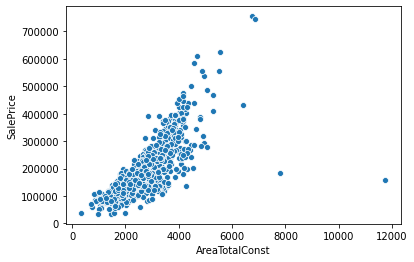

In [0]:
%matplotlib inline
sns.scatterplot(x='AreaTotalConst', y='SalePrice', data=train)

Podemos ver que há dois valores bem distintos no gráfico. Ambos são de casas que possuem área construida acima de 6.000 ft² e valor de venda abaixo de $300.000.

Esses são valores incoerentes com a realidade, e que podem prejudicar o aprendizado do nosso modelo, por isso vamos removê-los.

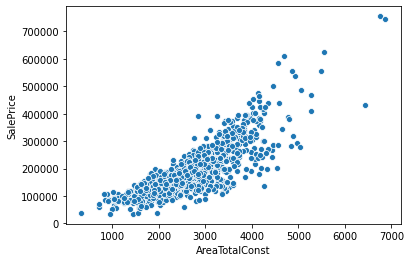

In [0]:
train = train.drop(train[(train['AreaTotalConst'] > 6000) & (train['SalePrice'] < 300000)].index)

sns.scatterplot(x='AreaTotalConst', y='SalePrice', data=train)

### Analisando a Variável Alvo

A coluna para a qual queremos fazer as previsões é a 'SalePrice', então vamos analisar a  distribuição dos dados dessa coluna.

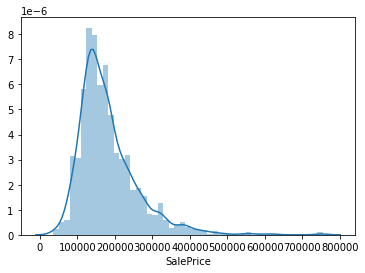

In [0]:
%matplotlib inline
sns.distplot(train['SalePrice'])

No melhor cenário, a o gráfico acima deveria apresenter um formato de distribuição normal ou gaussiana, ou seja, em forma de sino, centralizado. Isso é importante pois os algorítimos tendem a ter um melhor desempenho quando temos dados nessa configuração.

Podemos conseguir esse resultado forçando os dados à uma transformação logarítmica.

In [0]:
train['SalePriceLog'] = np.log(train['SalePrice'])

vamos verificar novamente...

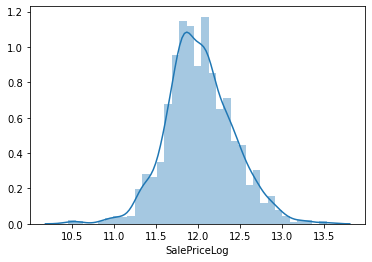

In [0]:
sns.distplot(train['SalePriceLog'])

Parece bem melhor agora. Podemos dar início à construção do nosso modelo.

Separando os dados

vamos começar separando os dados

In [0]:
X = train[variaveis]
y = train['SalePriceLog']

A variável X recebe os valores das features, exceto a variável alvo.

E a variável y recebe os valores da variável alvo.

Agora vamos separar 70% dos dados para treino e 30% para a validação do modelo.

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [0]:
X_train.shape, y_train.shape

((1020, 34), (1020,))

In [0]:
X_val.shape, y_val.shape

((438, 34), (438,))

### Random Forest

Muito bem, a primeia coisa que vamos fazer é verificar quais são os hiperparâmetros da Random Forest.

Para isso, vamos utilzar o método "get_params()".

E não, eu não escrevi errado. O "pprint" é uma função do Python que nos retorna um "Pretty Print", ou seja, um Print bonito, bem organizado, que vai nos auxiliar na exibição dos valores dos hiperparâmetros.

In [0]:
rf = RandomForestRegressor()
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Nosso algoritmo possui 18 hiperparâmetros.

Testar uma combinção ideal de valores a fim de otimizar o desempenho do algoritimo parece ser uma tarefa que irá tomar muito tempo.

Para reduzir nosso trabalho, vamos trabalhar com apenas 6 destes hiperparâmetros:
* n_estimators - número de árvores na floresta;
* max_features - O número de features a serem considerados ao procurar a melhor divisão;
* max_depth - profundidade máxima das árvores;
* min_samples_split - Número mínimo de amostras necessárias para dividir um nó interno;
* min_samples_leaf - O número mínimo de amostras necessárias para estar em um nó folha;
* bootstrap - Se as amostras de autoinicialização serão usadas na construção de árvores. Se False, o conjunto de dados inteiro é usado para criar cada árvore

Não vamos nos aprofundar demais nos hiperparâmetros individualmente. O que queremos é entender como o resultado do modelo é afetado pela combinação de valores desses hiperparâmetros.

Vamos criar uma função para facilitar nossa vida

### Função para gerar modelos de Random Forest

In [0]:
def modelTest(n_estimator, max_feature, max_dep, min_sample_split, min_sample_leaf, boot):
    rf = RandomForestRegressor(n_estimators=n_estimator, max_features=max_feature, 
                               max_depth=max_dep, min_samples_split=min_sample_split,
                               min_samples_leaf=min_sample_leaf, bootstrap=boot)
    
    rf.fit(X_train, y_train)
    pred = rf.predict(X_val)
    r2 = r2_score(y_val, pred)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    rmsle = np.sqrt(mean_squared_log_error(y_val, pred))

    print('R²: ' + str(r2)[0:6])
    print('RMSE: ' + str(rmse)[0:6])
    print('RMSLE: ' + str(rmsle)[0:6])

O funcionamento dessa função é bastante simples. Ela irá receber os valores dos hiperperâmetros definidos, treinar e testar a RandomForest.

Depois, ela nos retorna os valores da métricas R², RMSE e RMSLE, que podem ser explicados de maneira simples como:

* R² - Coeficiente de Determinção, que expressa a quantidade de variência dos dados que é explicada pelo modelo.

* RMSE - Root Mean Square Error ou Raiz do Erro Médio Quadrático, que é o valor da raiz do erro médio quadrático da diferença entre o valor real e o previsto.

* RMSLE - Root Mean Square Log Error, funciona de forma análoga ao RMSE, porém, utilza valores logaritmos.

Agora que já temos uma boa base teórica do funcionamento da nossa função, vamos criar alguns modelos e ver seu desempenho.

### Modelo 1

Vamos começar passando os seguintes valores à nossa função:
* n_estimators = 200;
* max_features = 'auto';
* max_depth = 10;
* min_samples_split = 2;
* min_samples_leaf = 1;
* bootstrap = False.


Para que o desempenho do modelo seja considerado bom, precisamos que os valores de R² sejam o mais próxmio possivel de 1 e os valores de RMSE e RMSLE sejam o mais próximo possivel de 0.

In [0]:
modelTest(200, 'auto', 10, 2, 1, False)

R²: 0.7665
RMSE: 0.1915
RMSLE: 0.0148


Este modelo não parece muito bom, vamos continuar testando.

### Modelo 2

Vamos alterar apenas o valor de 'max_features' para 'sqrt'.

In [0]:
modelTest(200, 'sqrt', 10, 2, 1, False)

R²: 0.8672
RMSE: 0.1444
RMSLE: 0.0113


Essa pequena alteração elevou nosso R² de 0.7665 para 0.8672, e reduziu os valores de RMSE de 0.1915 para 0.1444 e RMSLE de 0.0148 para 0.0113.

Mas o que aconteceria se alteracemos o valor de 'bootstrap' de False para True?

### Modelo 3

In [0]:
modelTest(200, 'sqrt', 10, 2, 1, True)

R²: 0.8604
RMSE: 0.1480
RMSLE: 0.0116


Nada bom. Essa alteração reduziu nosso R² de 0.8672 para 0.8604 e elevou nosso valores de RMSE de 0.1444 para 0.1480 e RMSLE de 0.0113 para 0.0116.

E se mantivermos o valor de 'bootstrap' = False e alterarmos o 'max_depth' de 10 para 100?

### Modelo 4

In [0]:
modelTest(200, 'sqrt', 100, 2, 1, False)

R²: 0.8671
RMSE: 0.1444
RMSLE: 0.0113


Já deu pra entender né?

Testar os valores dos hiperparâmetros manualmente seria uma tarefa exaustiva e interminável.

É por isso que existem ferramentas para nos ajudar a fazer esse 'tunning' nos valores. Uma delas é o GridSerachCV. 

Vamos dar uma olhada no seu funcionamento.



### GridSearchCV

O GridSerach é uma ferramenta que nos permite criar um dicionário de valores para os hiperparâmetros do nosso modelo, e testar todas as combinaçãoes possíveis entre eles.

Vamos ver isso na prática.


Primeiro, vamos instanciar o modelo, passando apenas dois parâmetros que queremos manter em todos os testes, 'random_state=42' e 'n_jobs=-1'.

In [0]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

Agora vamos criar um dicionário contendo os hiperparâmetros que queremos testar e atribuindo uma séria de valores à eles.

In [0]:
parameters = {'n_estimators': [100, 200],
              'max_features': ['auto', 'sqrt'],
              'max_depth': [10, 50],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 3],
              'bootstrap': [True, False]
              }

Então criamos o nosso grid, passando à ele o modelo e a lista de parâmetros criados.

In [0]:
grid = GridSearchCV(rf, parameters, verbose=1, scoring='r2')

Agora vamos treinar o modelo por meio do grid e usar os métodos 'best_estimator_' e 'best_score_' para nos retornar a melhor combinação de valores e a melhor pontuação.

In [0]:
grid.fit(X_train, y_train)

print('Melhor Modelo: ' + str(grid.best_estimator_))
print('Best Score: ' + str(grid.best_score_))

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  4.5min finished


Melhor Modelo: RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
Best Score: 0.8684221719703858


O GridSearch rodou 320 possíveis ajustes entre os hiperparâmetros.

A melhor combinção de valores foi:
* n_estimators = 200;
* max_features = 'sqrt';
* max_depth = 50;
* min_samples_split = 2;
* min_samples_leaf = 1;
* bootstrap = False;


Agora podemos retreinar nosso modelo, passando à ele os melhores valores testados pelo GridSearchCv.

In [0]:
rf = grid.best_estimator_

E executamos o restante do processo, que já vimos acima.

In [0]:
rf.fit(X_train, y_train)
pred = rf.predict(X_val)
r2 = r2_score(y_val, pred)
rmse = np.sqrt(mean_squared_error(y_val, pred))
rmsle = np.sqrt(mean_squared_log_error(y_val, pred))

print('R² Score: ' + str(r2)[0:6])
print('RMSE Score: ' + str(rmse)[0:6])
print('RMSLE Score: ' + str(rmsle)[0:6])

R² Score: 0.8649
RMSE Score: 0.1456
RMSLE Score: 0.0114


E pra concluir, podemos fazer a validação cruzada, que consiste em uma técnica utilzada para avaliar a capacidade de generalizaçao de um modelo.

In [0]:
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='r2')
print('Cross Validation Score: ' + str(np.mean(scores))[0:6])

Cross Validation Score: 0.8590


Nosso modelo teve uma pontuação inicial de 85,9% o que não é ruim. Mas é claro que aqui o intuito é apenas didatico.

Em condições reais o ideal seria testar maiores combinações de valores, a fim de otimizar os resultados.

No entando, por se tratar de um processo exaustivo de combinações, o GridSearch pode se mostrar um tanto lento dependendo do tamanho da lista de valores passada.

Existem outras ferramentas para nos auxiliar com esses testes, como a RandomSearchCV, mas isso é assunto pra outro artigo.

Muito obrigado por ter chegado até aqui, espero de alguma forma ter contibuido com o seu conhecimento.

O código completo utilizado no artigo você encontra no link abaixo.

Até a próxima!